In [58]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr #pip3 install --user finance-datareader
from fredapi import Fred
import datetime, os

import matplotlib.pyplot as plt

In [59]:
#ticker='msft aapl goog'#'SPY'
tickers=['QQQ','GLD']
yf.pdr_override()
df_price = pdr.get_data_yahoo(tickers)
df_price.isnull().sum()
df_price.dropna(axis=0,inplace=True)

[*********************100%***********************]  2 of 2 completed


In [60]:
start = df_price.index[0] 
end   = df_price.index[-1]
df_new_index = pd.date_range(start,end)
df_price = df_price.reindex(df_new_index)

df_price.isna().sum()
df_price.replace(np.NaN, 0, inplace=True)
df_price[0:3]

Adj Close                 Close                  High             \
                  GLD        QQQ        GLD        QQQ        GLD        QQQ   
2004-11-18  44.380001  34.003872  44.380001  39.290001  44.490002  39.360001   
2004-11-19  44.779999  33.475933  44.779999  38.680000  44.919998  39.290001   
2004-11-20   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

                  Low                  Open                 Volume  \
                  GLD        QQQ        GLD        QQQ         GLD   
2004-11-18  44.070000  38.889999  44.430000  38.980000   5992000.0   
2004-11-19  44.470001  38.590000  44.490002  39.240002  11655300.0   
2004-11-20   0.000000   0.000000   0.000000   0.000000         0.0   

                         
                    QQQ  
2004-11-18   94901100.0  
2004-11-19  118448900.0  
2004-11-20          0.0

In [61]:
for today in df_price.index[1:]:
  for col in df_price.columns.values:
    if df_price[col][today] == 0:
      df_price[col][today] = df_price[col][today-datetime.timedelta(days=1)]

In [81]:
trading_df = pd.DataFrame(df_price['Close'])

etfs = np.array(trading_df.columns.values)[::-1]

trading_df[[etf+'_qty' for etf in etfs]]     = 0
trading_df[[etf+'_capital' for etf in etfs]] = 0
trading_df['Total'] = 0
trading_df[0:3]

,GLD,QQQ,QQQ_qty,GLD_qty,QQQ_capital,GLD_capital,Total
2004-11-18,44.380001,39.290001,0,0,0,0,0
2004-11-19,44.779999,38.680000,0,0,0,0,0
2004-11-20,44.779999,38.680000,0,0,0,0,0


In [82]:
import datetime
from dateutil import relativedelta

def get_pivot(year, month, day):
  pivot_date = datetime.datetime.strptime("%d-%d-%d"%(year,month,day), "%Y-%m-%d")
  return pivot_date

def get_next_month(today:datetime):
    nextmonth = today + relativedelta.relativedelta(months=1)
    return nextmonth

def set_reblancing_date(trading_df, start_date, end_date):
  trading_df['Pivot'] = 0
  trading_df.loc[start_date,'Pivot'] = 1
  trading_df.loc[end_date,'Pivot'] = 1
  iter_date = start_date
  while iter_date < end_date:
    AW_4_  = (iter_date.month==4)
    AW_11_ = (iter_date.month==11)
    if (AW_4_ or AW_11_):
      pivot_date = get_pivot(iter_date.year,iter_date.month,28)
      trading_df.loc[pivot_date,'Pivot'] = 1 
    iter_date = get_next_month(iter_date)
  return trading_df

In [83]:
# Sim Env
start_date = datetime.datetime.strptime('2021-01-03', '%Y-%m-%d')
end_date   = datetime.datetime.strptime('2022-03-28', '%Y-%m-%d')
period = (start_date <= trading_df.index) & (end_date >= trading_df.index)
trading_df = trading_df.loc[period]

init_capital = 1_000_000

trading_df = set_reblancing_date(trading_df,start_date, end_date)
trading_df[0:3]

,GLD,QQQ,QQQ_qty,GLD_qty,QQQ_capital,GLD_capital,Total,Pivot
2021-01-03,178.360001,313.739990,0,0,0,0,0,1
2021-01-04,182.330002,309.309998,0,0,0,0,0,0
2021-01-05,182.869995,311.859985,0,0,0,0,0,0


In [90]:
REBLANCING = 1
def buy_portpolio(trading_df, init_capital ,etfs):
  capital = init_capital
  ratios = [0.75, 0.25] 
  budgets = (np.ones(len(etfs))*capital)*ratios
  qtys   = (budgets/ trading_df.loc[trading_df.index[0],etfs].values).astype(int)

  for i, etf in enumerate(etfs):
    trading_df.loc[:, etf+'_qty'] = qtys[i] 
    trading_df[etf+'_capital'] = trading_df[etf+'_qty']*trading_df[etf]
  
  if REBLANCING:
    trading_df['Total'] = trading_df[[etf+'_capital' for etf in etfs]].sum(axis=1)
  trading_df['Yield'] = (trading_df['Total']-capital)/capital*100
  trading_df['MDD'] = 0
  return trading_df

trading_df = buy_portpolio(trading_df, init_capital, etfs)
not_reblance = trading_df.copy()
trading_df[0:3]

,GLD,QQQ,QQQ_qty,GLD_qty,QQQ_capital,GLD_capital,Total,Pivot,Yield,MDD
2021-01-03,178.360001,313.739990,2390,1401,749838.576660,249882.360855,9.994072e+05,1,-0.059280,0
2021-01-04,182.330002,309.309998,2390,1401,739250.894165,255444.332565,9.943859e+05,0,-0.561408,0
2021-01-05,182.869995,311.859985,2390,1401,745345.364990,256200.863159,1.001234e+06,0,0.123437,0


CQGR: 4.05 %
CAGR: 12.64 %
CMGR: 0.85 %
MDD: -14.41 %


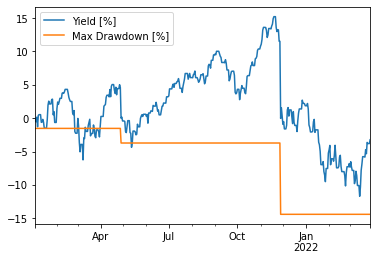

In [91]:
# Reblancing
index = trading_df.loc[trading_df['Pivot']==True,:].index.values

for i in range(len(index)-1):
  period = (index[i] <= trading_df.index) & (index[i+1] >= trading_df.index)
  quater_df = trading_df.loc[period,:].copy()
  
  quater_capital = 0
  for etf in etfs:
    quater_capital = quater_capital + quater_df.iloc[0].xs(etf+'_capital')
  quater_df = buy_portpolio(quater_df, quater_capital, etfs)

  # MDD
  maximum = quater_df['Yield'][quater_df['Yield'].idxmax()]
  minimum = quater_df['Yield'].loc[  (quater_df['Yield'].idxmax()<=quater_df.index)].min()
  quater_df['MDD'] = minimum-maximum
  trading_df.loc[period,:] = quater_df

# CQGR ,CAGR
cqgr = (trading_df['Total'][-1] / init_capital)**(1/(len(index)-1))
cqgr = round((cqgr-1)*100,2)
print('CQGR: %.2f %%'%cqgr)

years = (end_date.year-start_date.year)
years = years if years else 1
cagr = (trading_df['Total'][-1] / init_capital)**(1/(years))
cagr = round((cagr-1)*100,2)
print('CAGR: %.2f %%'%cagr)

months = ((end_date.year-start_date.year)*12 + (end_date.month-start_date.month))
months = months if months else 1
cmgr = (trading_df['Total'][-1] / init_capital)**(1/months)
cmgr = round((cmgr-1)*100,2)
print('CMGR: %.2f %%'%cmgr)


# MDD
mdd = trading_df['MDD'].min()
print('MDD: %.2f %%'%mdd)


#trading_df[['QQQ_capital', 'GLD_capital']].plot()
trading_df['Yield'].plot(label='Yield [%]')
trading_df['MDD'].plot(label='Max Drawdown [%]')
plt.legend()
#plt.ylabel('[%]')

<AxesSubplot:>

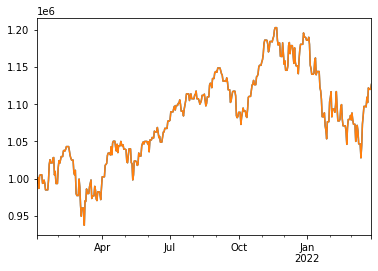

In [92]:
#trading_df[['QQQ_capital', 'GLD_capital']].plot()
not_reblance['Total'].plot()
trading_df['Total'].plot()